# Analysis of Nea. ancestry

In [1]:
setwd("../../slim-neanderthal/notebooks/")

In [2]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [4]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [5]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [6]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.transitions.snp")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [7]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

### Generate a table of SNPs to filter out (transitions)

In [8]:
read_fwf(SNP_FILE,
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


In [9]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai
* O - Chimp


![](img/ice_age_f4_description.png)

In [10]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Nea=c("new_Altai", "new_Vindija")))

In [11]:
my_iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Nea", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

In [12]:
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

Ben Peter's suggestion - should give the same results.

In [13]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [14]:
results <- bind_rows(list(my_iceage_Nea,
                          mbuti,
                          yoruba,
                          dinka)) %>% mutate(name=X, method=setup)

In [15]:
table(results$method)


        qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                 158 
        qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                 158 
       qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                 158 
qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp 
                                                 158 

# Plot Nea. estimates over time

So far we have been focusing on evaluating various scenarios of selection that could reproduce the decrease in Neanderthal ancestry that we reported in the Ice Age paper [@fu_genetic_2016]. As a reminder, this is the slope of Neanderthal ancestry form the paper that we are trying to fit:

In [16]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# combine tables with both estimates into a single table for comparison and merge
# them with counts of SNPs per sample on both admixture array and 2.2M sites arrays
all_nea_estimates <- inner_join(samples, bind_rows(mutate(inner_join(direct_nea, snp_counts_direct), Zscore = Inf),
                                               inner_join(results, snp_counts_f4))) %>%
    select(name, age, pop, alpha, method, snp_count, Zscore)

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"


In [17]:
nea_estimates <- all_nea_estimates %>% 
    filter(pop %in% c("EMH", "WestEurasia"),
                      !name %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                                   "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                      !name %in% non_udg_samples)

In [18]:
filter(nea_estimates, name == "UstIshim")

name,age,pop,alpha,method,snp_count,Zscore
UstIshim,45020,EMH,0.02797917,direct,157653,Inf
UstIshim,45020,EMH,0.04529900,qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp,1637960,9.517
UstIshim,45020,EMH,0.02286200,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,1637960,5.775
UstIshim,45020,EMH,0.02670900,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,1637960,6.854
UstIshim,45020,EMH,0.02532600,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,1637960,6.681


In [19]:
plot_nea_vs_time <- function(m, age_cutoff=-Inf, ylim=c(0, 0.05)) {
    filter(nea_estimates,
           method == m,
           age > age_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > 3), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) +
        ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, zscore=0, snp_cutoff=0, age_cutoff=-Inf) {
    filter(nea_estimates,
           method == m,
           snp_count >= snp_cutoff,
           age >= age_cutoff,
           is.na(Zscore) | abs(Zscore) >= zscore) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) } %>% 
    summary
}

## Results from the Ice Age paper

In [20]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3467606  -105192   517624  1049777  2525788 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -63609      19060  -3.337 0.004885 ** 
.[["alpha"]]  3733341     761271   4.904 0.000233 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1582000 on 14 degrees of freedom
Multiple R-squared:  0.6321,	Adjusted R-squared:  0.6058 
F-statistic: 24.05 on 1 and 14 DF,  p-value: 0.0002325


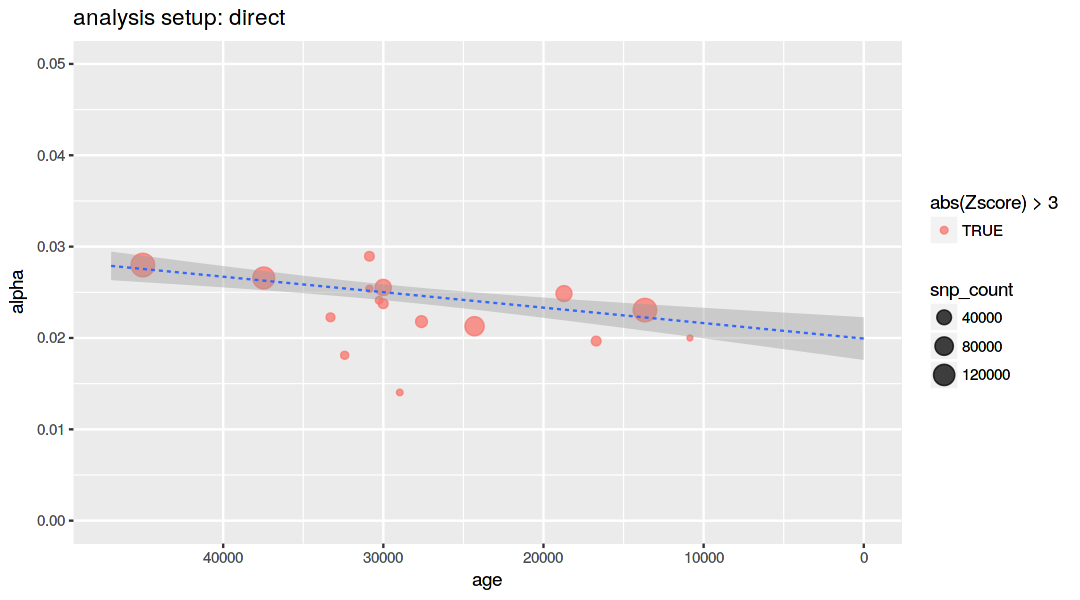

In [22]:
plot_nea_vs_time("direct", age_cutoff = 10000)
run_lm("direct", age_cutoff = 10000)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3365749  -733145   327061  1377561  4849830 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -65544       6189  -10.59 8.37e-14 ***
.[["alpha"]]  3515114     321587   10.93 2.98e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2043000 on 45 degrees of freedom
Multiple R-squared:  0.7264,	Adjusted R-squared:  0.7203 
F-statistic: 119.5 on 1 and 45 DF,  p-value: 2.978e-14


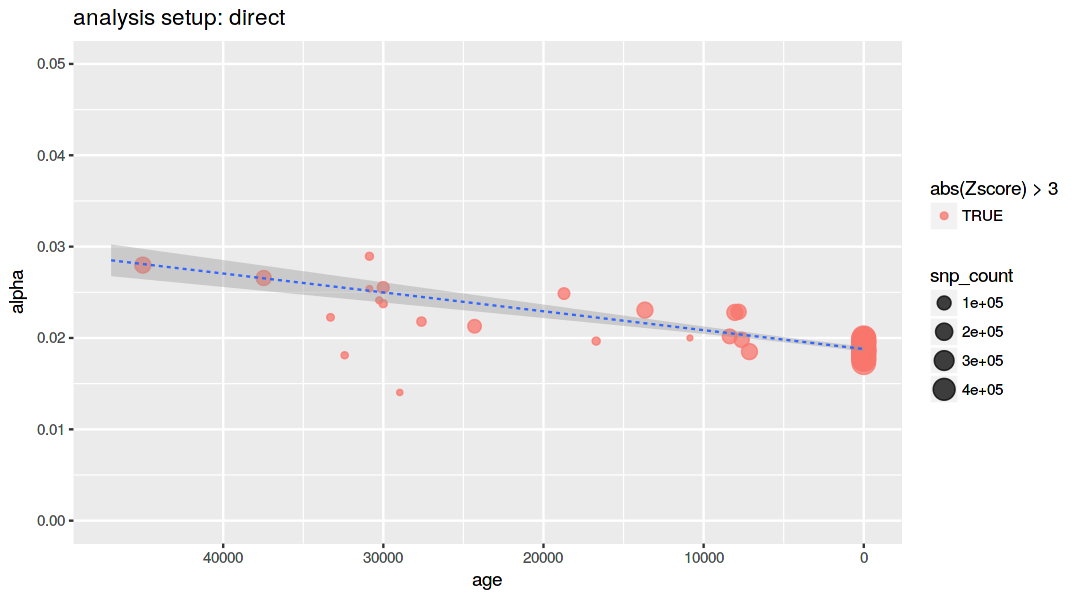

In [24]:
plot_nea_vs_time("direct")
run_lm("direct")

Warning message:
“Removed 3 rows containing missing values (geom_point).”

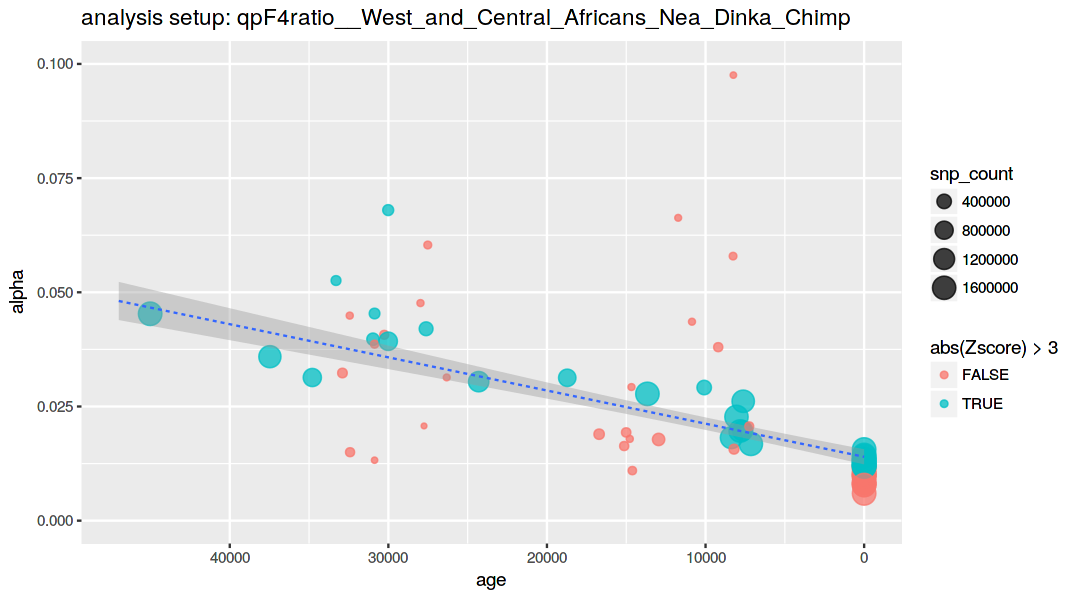

In [25]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp", ylim=c(0, 0.1))

# New f4 results

In [26]:
options(repr.plot.width=9, repr.plot.height=5)

Warning message:
“Removed 5 rows containing missing values (geom_point).”

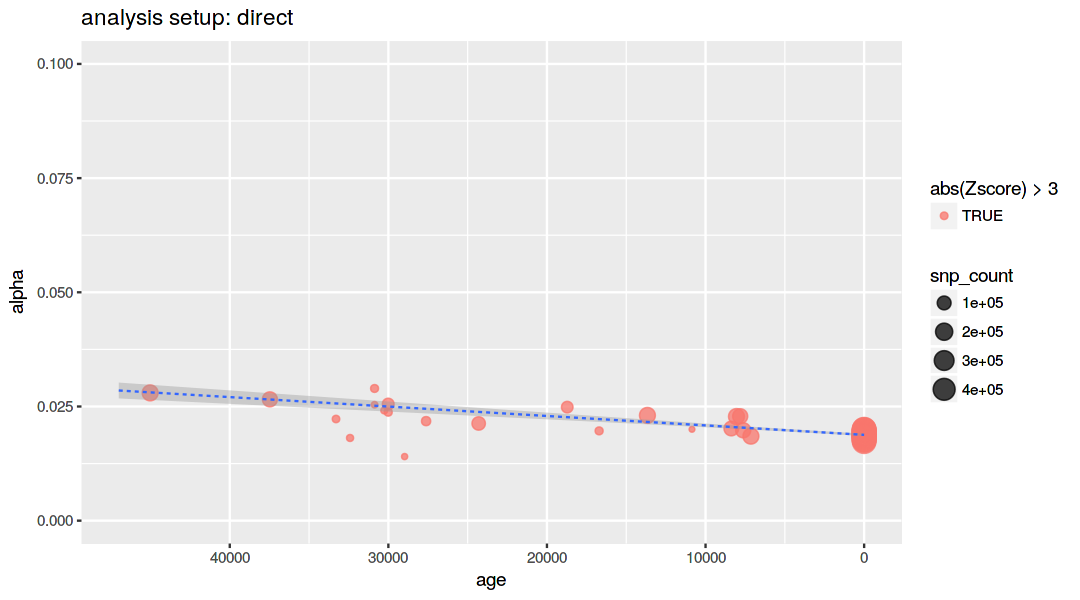

Warning message:
“Removed 5 rows containing missing values (geom_point).”

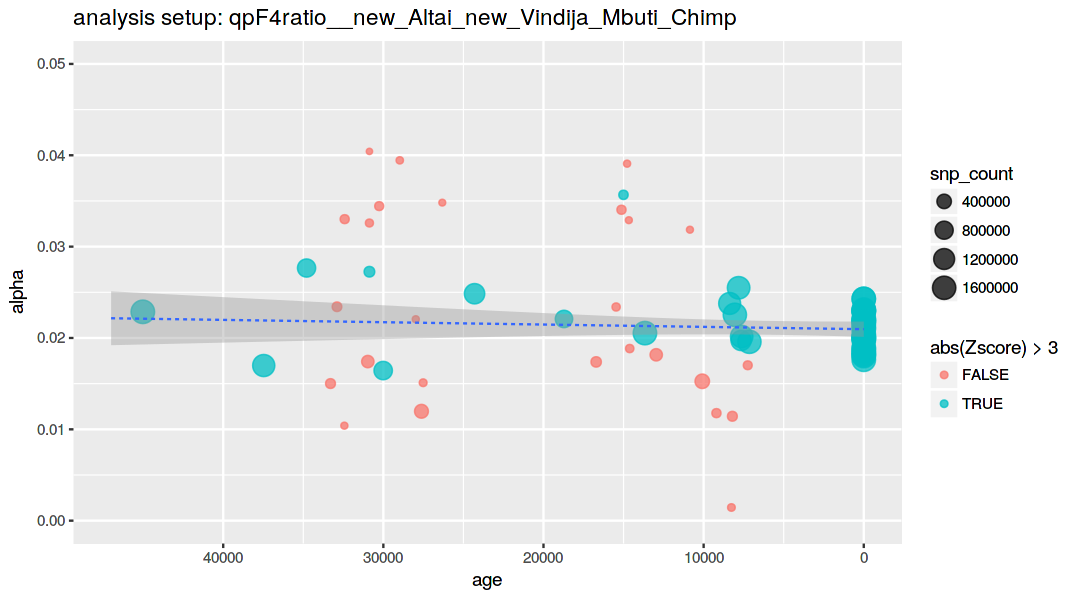

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

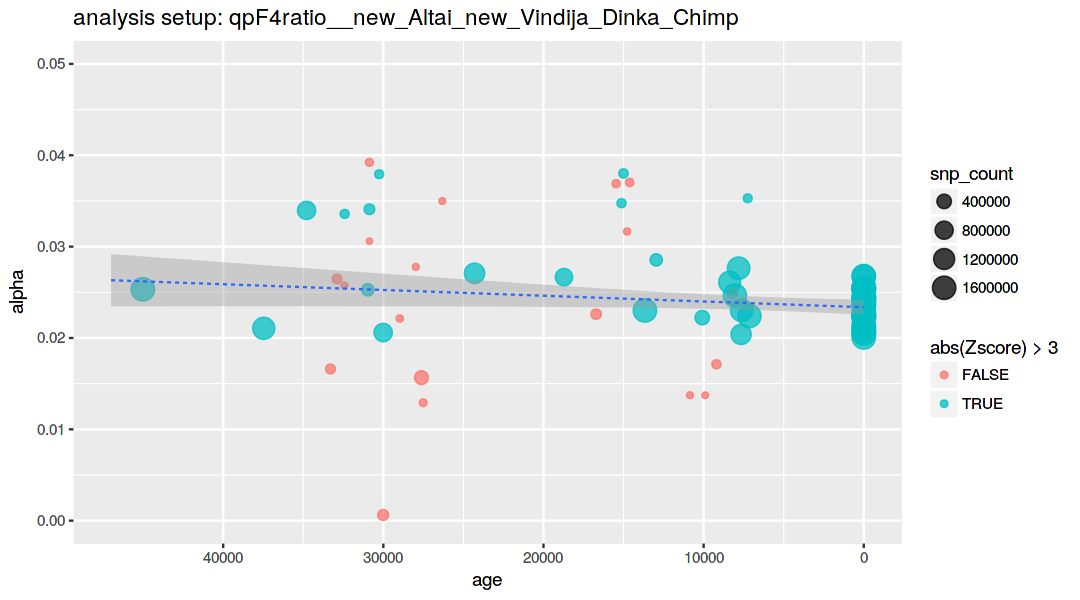

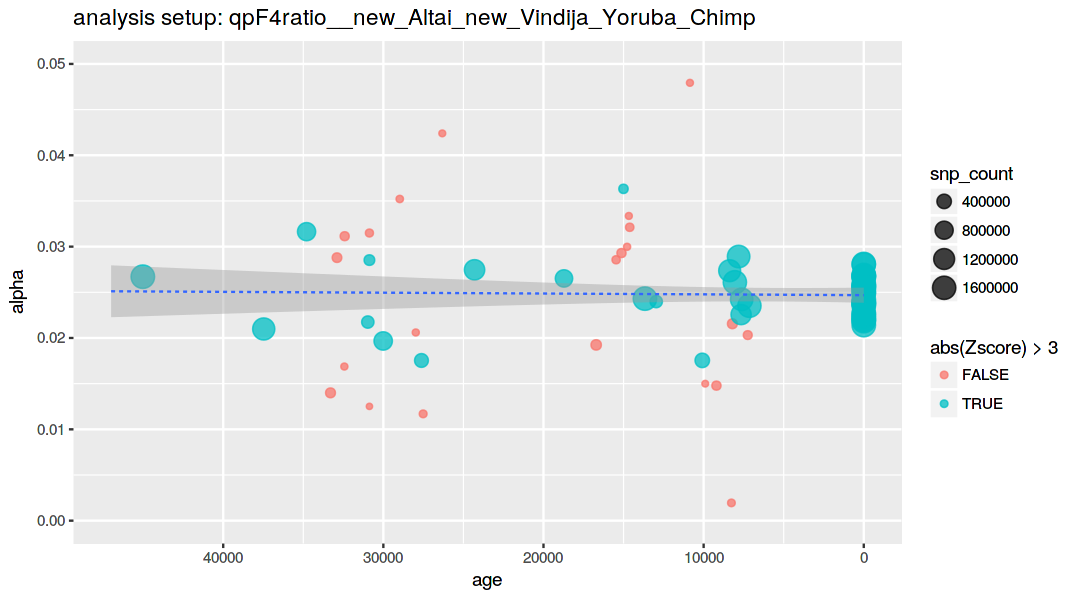

In [28]:
plot_nea_vs_time("direct", ylim=c(0, 0.1))
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")

In [30]:
save.image("../../nea-over-time/data/RData/admixtools_nea_ancestry.RData")